# EDA

In [9]:
#Import librairies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
from prophet import Prophet

import boto3
import os
from dotenv import load_dotenv
print(load_dotenv())
import io

True


In [10]:
session = boto3.Session(aws_access_key_id=os.environ["AWS_ACCESS_KEY"], 
                        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"])

s3 = session.client("s3")
obj = s3.get_object(Bucket="les-derniers-flocons-project", Key='donnees_meteo_148_stations.csv')

In [11]:
df = pd.read_csv(io.BytesIO(obj['Body'].read()))
df.head()

,Unnamed: 0_x,date,latitude,longitude,temperature_2m_mean,snowfall_sum,rain_sum,cloud_cover_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,snowfall_water_equivalent_sum,wind_speed_10m_mean,soil_temperature_0_to_100cm_mean,Unnamed: 0_y,stations,altitude
0,20149,1970-01-01 00:00:00+00:00,45.562302,6.838686,-13.889000,0.00,0.0,94.916664,-10.9015,-16.9515,25632.137,0.000000,3.488933,0.186000,106.0,Les Arcs,2347.0
1,20150,1970-01-02 00:00:00+00:00,45.562302,6.838686,-14.241082,0.00,0.0,44.500000,-10.5515,-17.9515,26718.748,0.000000,2.068126,0.177687,106.0,Les Arcs,2347.0
2,20151,1970-01-03 00:00:00+00:00,45.562302,6.838686,-12.757751,0.00,0.0,0.666667,-9.2515,-14.7515,27195.508,0.000000,1.034605,0.167646,106.0,Les Arcs,2347.0
3,20152,1970-01-04 00:00:00+00:00,45.562302,6.838686,-12.966084,12.60,0.0,84.041664,-10.5015,-16.8515,0.000,18.000000,6.055424,0.130750,106.0,Les Arcs,2347.0
4,20153,1970-01-05 00:00:00+00:00,45.562302,6.838686,-8.966083,6.93,0.0,94.583336,-7.2515,-10.8515,13470.034,9.900001,5.796110,0.123167,106.0,Les Arcs,2347.0


In [12]:
df['date'] = pd.to_datetime(df['date'])

### Temperature

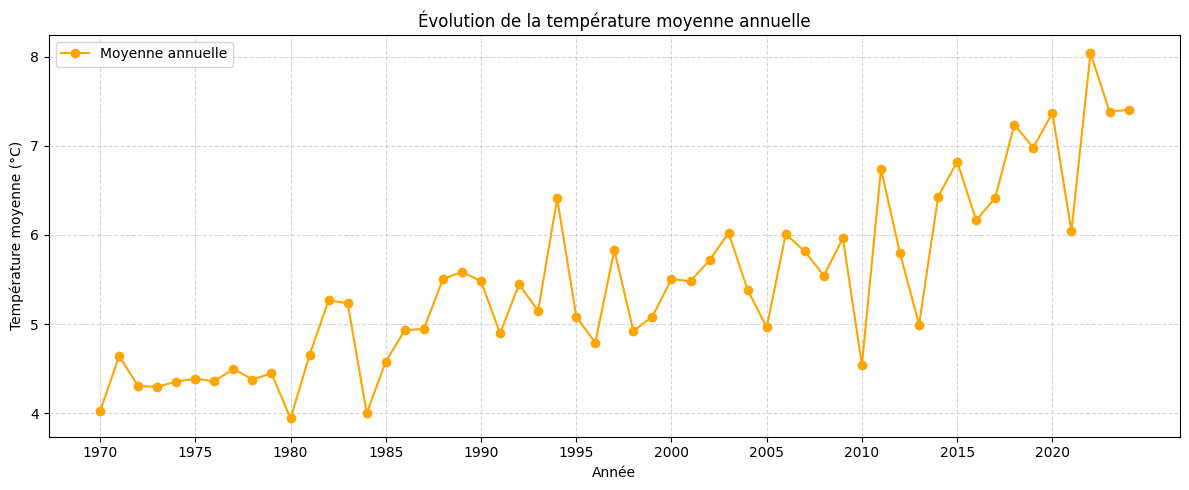

In [13]:
df['year'] = df['date'].dt.year

# Delete 2025 (incomplete data for this year)
df_filtered = df[df['year'] < 2025]

# Temperature mean
df_yearly_mean = df_filtered.groupby('year')['temperature_2m_mean'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_yearly_mean['year'], df_yearly_mean['temperature_2m_mean'],
         marker='o', color='orange', label='Moyenne annuelle')

plt.title("Évolution de la température moyenne annuelle")
plt.xlabel("Année")
plt.ylabel("Température moyenne (°C)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(ticks=range(df_yearly_mean['year'].min(), df_yearly_mean['year'].max()+1, 5))
plt.tight_layout()
plt.show()

### Precipitation

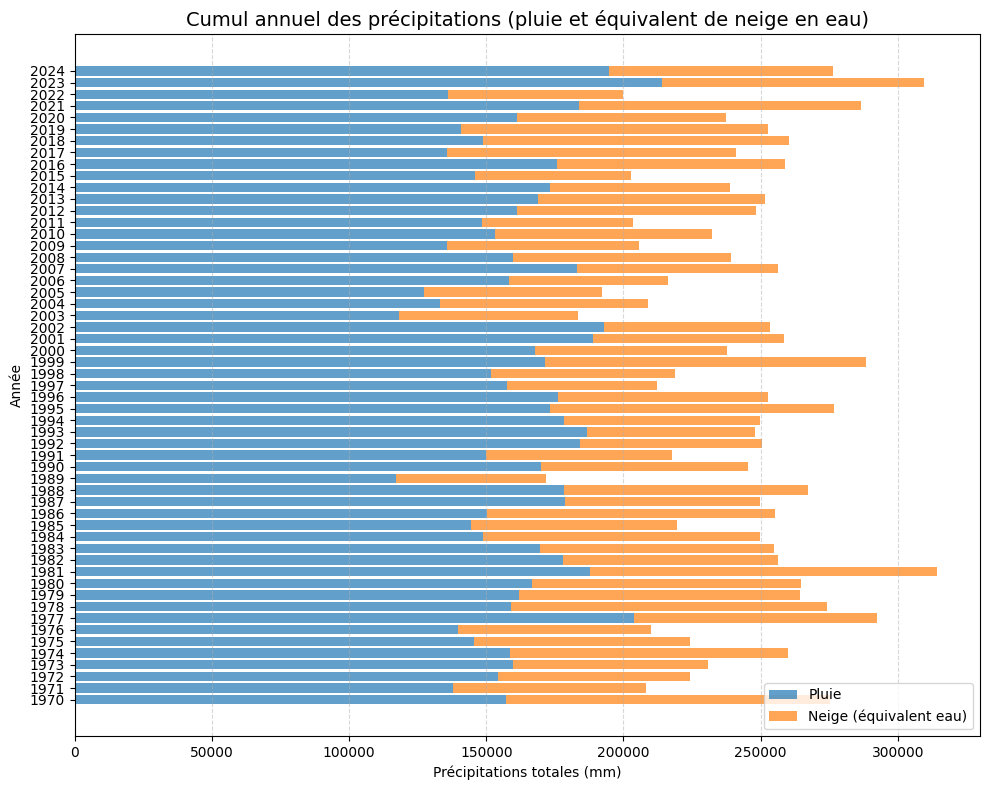

In [14]:
df['year'] = df['date'].dt.year
df_yearly = df.groupby('year')[['rain_sum', 'snowfall_water_equivalent_sum']].sum().reset_index()

df_yearly = df_yearly[df_yearly['year'] != 2025]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(df_yearly['year'], df_yearly['rain_sum'], label='Pluie', alpha=0.7)
plt.barh(df_yearly['year'], df_yearly['snowfall_water_equivalent_sum'],
         left=df_yearly['rain_sum'], label='Neige (équivalent eau)', alpha=0.7)
plt.title('Cumul annuel des précipitations (pluie et équivalent de neige en eau)', fontsize=14)
plt.ylabel('Année')
plt.xlabel('Précipitations totales (mm)')
plt.yticks(df_yearly['year'])
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Snowfall

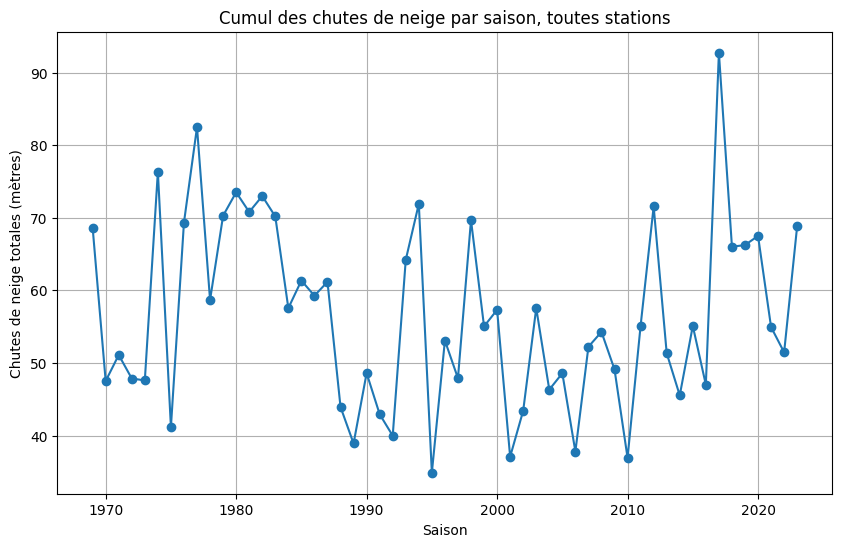

In [15]:
df = df[df['date'] < '2024-08-01']
df['season'] = df['date'].apply(lambda x: x.year if x.month >= 8 else x.year - 1)

seasonal_snowfall = df.groupby('season')['snowfall_sum'].sum().reset_index()

# Convert in meters
seasonal_snowfall['snowfall_sum'] = seasonal_snowfall['snowfall_sum'] / 1000
seasonal_snowfall = seasonal_snowfall.sort_values('season')

# Plot
plt.figure(figsize=(10,6))
plt.plot(seasonal_snowfall['season'], seasonal_snowfall['snowfall_sum'], marker='o')
plt.xlabel('Saison')
plt.ylabel('Chutes de neige totales (mètres)')
plt.title('Cumul des chutes de neige par saison, toutes stations')
plt.grid(True)
plt.show()
